In [2]:
import math
import os
import random

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
import json
from collections import defaultdict
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import sys

In [3]:
sys.path.append('/home/krishna/Projects/VLN-DUET/build')
os.environ['LD_LIBRARY_PATH'] = '/home/krishna/Projects/VLN-DUET/map_nav_src'
import MatterSim

ImportError: libMatterSim.so: cannot open shared object file: No such file or directory

In [152]:
def new_simulator(connectivity_dir, scan_data_dir=None):
    import MatterSim

    # Simulator image parameters
    WIDTH = 1024
    HEIGHT = 720
    VFOV = 90

    sim = MatterSim.Simulator()
    if scan_data_dir:
        sim.setDatasetPath(scan_data_dir)
    sim.setNavGraphPath(connectivity_dir)
    sim.setRenderingEnabled(False)
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setDepthEnabled(False)
    sim.setCameraVFOV(math.radians(VFOV))
    sim.setDiscretizedViewingAngles(True)
    sim.setBatchSize(1)
    sim.initialize()

    return sim

In [153]:
ROOTDIR = 'datasets'

connectivity_dir = os.path.join(ROOTDIR, 'R2R', 'connectivity')
scan_data_dir = os.path.join('/home/krishna/Projects/Matterport3DSimulatorDocker/data', 'v1', 'scans')

In [154]:
sim = new_simulator(connectivity_dir, scan_data_dir)


In [6]:
sim.newRandomEpisode(['EU6Fwq7SyZv'])

In [7]:
state = sim.getState()[0]
locations = state.navigableLocations
rgb = np.array(state.rgb, copy=False)

In [ ]:
rgb.max()

In [82]:
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)



In [83]:
def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
    plt.show(block=False)

def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.enable_physics = settings["enable_physics"]

    # Note: all sensors must have the same resolution
    sensor_specs = []
    
    if settings['color_sensor']:
        if settings['color_sensor_equi']:
            color_sensor_spec = habitat_sim.EquirectangularSensorSpec()
            color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.EQUIRECTANGULAR
        else:
            color_sensor_spec = habitat_sim.CameraSensorSpec()
            color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
        color_sensor_spec.uuid = "color_sensor"
        color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
        color_sensor_spec.resolution = [settings["height"], settings["width"]]
        color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
        
        sensor_specs.append(color_sensor_spec)
    
    if settings['depth_sensor']:
        if settings['depth_sensor_equi']:
            depth_sensor_spec = habitat_sim.EquirectangularSensorSpec()
            depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.EQUIRECTANGULAR
        else:
            depth_sensor_spec = habitat_sim.CameraSensorSpec()
            depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
        depth_sensor_spec.uuid = "depth_sensor"
        depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
        depth_sensor_spec.resolution = [settings["height"], settings["width"]]
        depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]

        sensor_specs.append(depth_sensor_spec)
    if settings['semantic_sensor']:
        if settings['semantic_sensor_equi']:
            semantic_sensor_spec = habitat_sim.EquirectangularSensorSpec()
            semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.EQUIRECTANGULAR
        else:
            semantic_sensor_spec = habitat_sim.CameraSensorSpec()
            semantic_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE

        semantic_sensor_spec.uuid = "semantic_sensor"
        semantic_sensor_spec.sensor_type = habitat_sim.SensorType.SEMANTIC
        semantic_sensor_spec.resolution = [settings["height"], settings["width"]]
        semantic_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
        sensor_specs.append(semantic_sensor_spec)

    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=30.0)
        ),
    }

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


In [84]:

# with gzip.open(f'./data/datasets/R2R_VLNCE_v1-2_preprocessed_BERTidx/{split}/{split}_bertidx.json.gz') as r2rgz:
#     json_file = json.load(r2rgz)
#     episodes = json_file['episodes']

In [85]:
episodes = []
with open(f'./map_nav_src/R2R/exprs_map/finetune/dagger--seed.0-init.aug.45k-prefr-ft-fr_reverse_blip2/preds/detail_val_unseen.json') as r2rgz:
    json_file = json.load(r2rgz)
    val_unseen_epi = json_file
with open(f'./map_nav_src/R2R/exprs_map/finetune/dagger--seed.0-init.aug.45k-prefr-ft-fr_reverse_blip2/preds/detail_val_train_seen.json') as r2rgz:
    json_file = json.load(r2rgz)
    train_epis = json_file
with open(f'./map_nav_src/R2R/exprs_map/finetune/dagger--seed.0-init.aug.45k-prefr-ft-fr_reverse_blip2/preds/detail_val_seen.json') as r2rgz:
    json_file = json.load(r2rgz)
    val_seen_epis = json_file
episodes.extend(val_unseen_epi)
episodes.extend(train_epis)
episodes.extend(val_seen_epis)

In [11]:
for episode in episodes:
    episode['geodesic_distance'] = episode['info']['geodesic_distance']
    episode['goals'] = episode['goals'][0]['position']
    episode['instruction'] = episode['instruction']['instruction_text']
    del episode['info'] 

KeyError: 'info'

In [12]:
grouped_epis = group_episodes(val_seen_epis, [5, 10, 15, 20, 25])
grouped_epis.keys()

NameError: name 'group_episodes' is not defined

In [13]:
epi_df = pd.DataFrame.from_dict(train_epis)
epi_df.head()

CLS        DTW      SDTW  action_steps  \
0  0.309403  36.841175  0.000000             8   
1  0.094114  74.077192  0.000000             7   
2  0.822123   0.963634  0.947873             6   
3  0.466038  13.495368  0.000000             6   
4  0.581308   9.578767  0.000000             7   

                                             details instr_id      nDTW  \
0  {'0d2c70fefca244809696dde968e50174': {'stop_pr...    831_0  0.173021   
1  {'00ef8a0394f447c68796213e64155467': {'stop_pr...    319_2  0.007165   
2  {'2b718e682ee748bd8f192db63b7047ac': {'stop_pr...   1225_2  0.947873   
3  {'1416ceed767d46a9beba0aede50504ed': {'stop_pr...   3028_0  0.406695   
4  {'49d8e71cc67d45f9863ca6d25a61a2fa': {'stop_pr...   1014_2  0.633730   

   nav_error  oracle_error  oracle_success       spl  success  \
0  12.017835      5.893397             0.0  0.000000      0.0   
1  22.705381      8.726612             0.0  0.000000      0.0   
2   0.000000      0.000000             1.0  0.822123      1.0   
3   6.698129      1.349654             1.0  0.000000      0.0   
4   4.416628      3.398629             0.0  0.000000      0.0   

                                          trajectory  trajectory_lengths  \
0  [[0d2c70fefca244809696dde968e50174], [264445cc...           12.763894   
1  [[1aba6e328b4d4211900d8296b88f6127], [5e5ce62a...           17.291440   
2  [[c8ecc5b238f143d89d756449616c5798], [be56a194...            8.112499   
3  [[a358b83b1c6f4ee3bbabb66ac93be11b], [1416ceed...            9.488423   
4  [[c5fe339f452f4eddb9659f812c38c748], [4ed50a2f...           14.466927   

   trajectory_steps  
0                 8  
1                 7  
2                 6  
3                 6  
4                 8

In [ ]:
n_buckets = int((epi_df['geodesic_distance'].max() - epi_df['geodesic_distance'].min()) // 5)

In [ ]:
epi_df["geodesic_distance_rank"] = epi_df["geodesic_distance"].rank(method="dense", ascending=True).astype(int)

In [ ]:
epi_df.head()

In [ ]:
epi_df['geodesic_distance'].hist(bins=20, density=1, alpha=0.8)

In [ ]:
train_epis_df = pd.DataFrame.from_dict(train_epis)
train_epis_df['geodesic_distance_bin']  = (train_epis_df['geodesic_distance'] // 5 ).astype(int) * 5

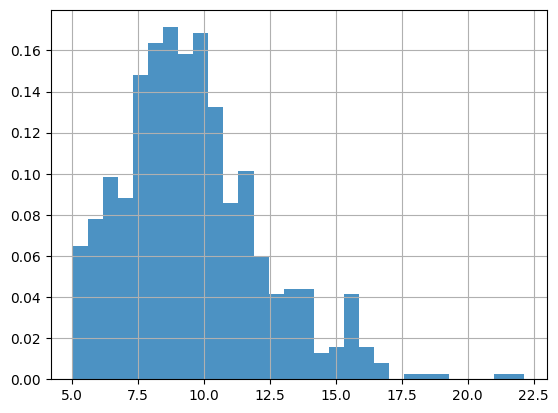

5


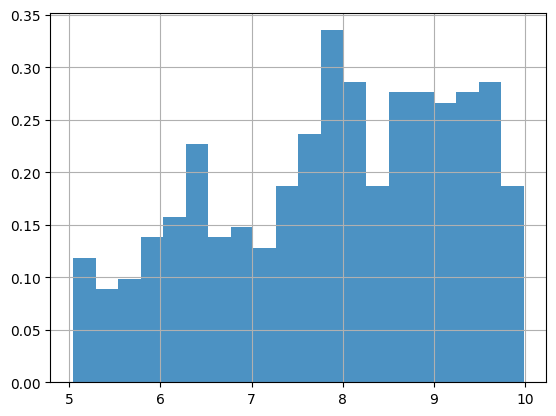

10


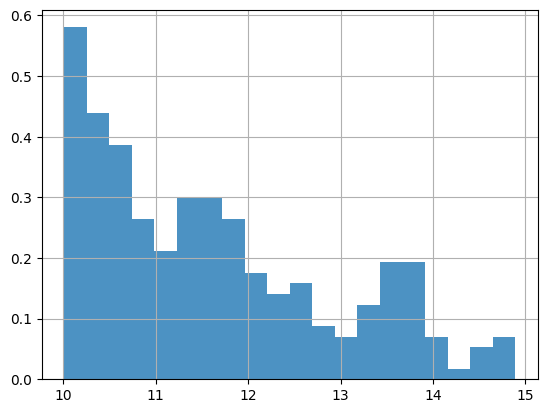

15


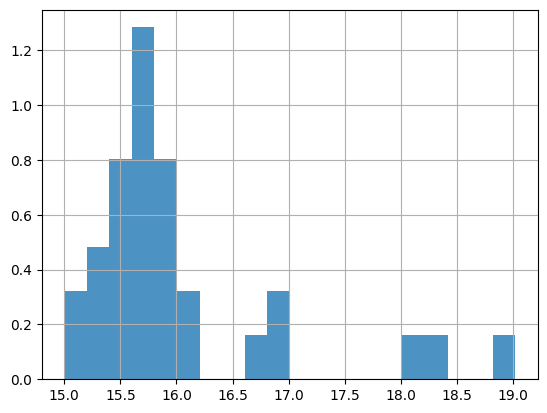

20


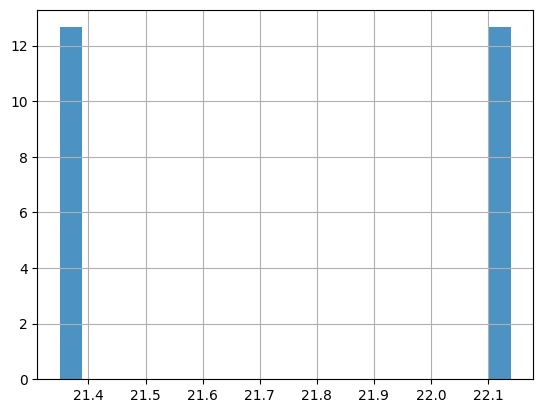

In [86]:
split = 'val_unseen'
traj_type = '_reverse'
with open(f'./datasets/R2R/annotations/R2R_{split}{traj_type}_enc.json') as r2rgz:
    json_file = json.load(r2rgz)
    episodes = json_file
episodes_df = pd.DataFrame.from_dict(episodes)
episodes_df['distance'].hist(bins=30, density=1, alpha=0.8)
plt.show()
episodes_df['distance_bin']  = (episodes_df['distance'] // 5 ).astype(int) * 5
grouped_episodes ={}
for name, group in episodes_df.groupby('distance_bin'):
    group['distance'].hist(bins=20, density=1, alpha=0.8)
    grouped_episodes[name] = group.to_dict('records')
    print(name)
    plt.show()
#     del group['distance']
#     del group['distance_bin']
#     with open(f'./datasets/R2R/annotations/R2R_{split}{traj_type}_{name}m_enc.json', 'wt',  encoding='UTF-8') as fileout:
#         json_file = group.to_dict('records')
#         json.dump(json_file, fileout)

In [ ]:
## ETP Forward
all_stats = []
for i, col in enumerate([5, 10, 15, 20, 25], start=1):
    with open(f'logs/eval_results/release_etp_{col}/stats_ckpt_59_val_unseen.json') as jsn_f:
        stats = json.load(jsn_f)
        all_stats.append(stats)
df = pd.DataFrame.from_records(all_stats, index=[0, 5, 10, 15, 20])
df

In [16]:
forward_episodes_stats = {}
# for i, col in enumerate([0, 5, 10, 15, 20], start=1):
#     with open(f'./map_nav_src/R2R/exprs_map/finetune/dagger--seed.0-init.aug.45k-prefr-ft-fr/preds/detail_{split}.json') as jsn_f:
#         episode_stats = json.load(jsn_f)
#         df = pd.DataFrame.from_records(episode_stats)
#         forward_episodes_stats[col] = df.T
reverse_episodes_stats = {}
for i, col in enumerate([5, 10, 15, 20, 25], start=1):
    with open(f'./map_nav_src/R2R/exprs_map/finetune/dagger--seed.0-init.aug.45k-prefr-ft-fr{traj_type}/preds/detail_{split}.json') as jsn_f:
        episode_stats = json.load(jsn_f)
        selected = episodes_df[episodes_df['distance_bin']==col]
        df = pd.DataFrame.from_records(episode_stats)
#         print(df.instr_id.str.split("_")[0][0])
        df['path_id'] = df['instr_id'].str.split("_", expand=True)[0]
        selected['path_id'] = selected['path_id'].astype(str)
        df = df.merge(selected, on='path_id', how='right', suffixes=('', '_right'))
        reverse_episodes_stats[col] = df
        print(df.head(5))


/tmp/ipykernel_1931453/1368291454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['path_id'] = selected['path_id'].astype(str)
/tmp/ipykernel_1931453/1368291454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['path_id'] = selected['path_id'].astype(str)


        CLS        DTW  SDTW  action_steps  \
0  0.414685  19.605357   0.0             7   
1  0.523143  11.289459   0.0             9   
2  0.678296   4.902601   0.0             6   
3  0.162635  55.556833   0.0             7   
4  0.163910  54.332278   0.0             6   

                                             details instr_id      nDTW  \
0  {'06bd0a2d004b454b9e93ddcf08344732': {'stop_pr...   2390_2  0.336490   
1  {'062a2a53b6fd44ea8bc55cc1dfa859ae': {'stop_pr...   2390_0  0.534089   
2  {'01cada103ecb4ad3864861c13baee57d': {'stop_pr...   2390_1  0.761575   
3  {'2dfcc64b0482418e939acd1717e8c470': {'stop_pr...    237_0  0.070965   
4  {'309ce5b44bfd45bca3a4a1d9ed335740': {'stop_pr...    237_2  0.075227   

   nav_error  oracle_error  oracle_success  ...  trajectory_steps  path_id  \
0   7.391296      1.562608             1.0  ...                 7     2390   
1   4.696811      0.000000             1.0  ...                 9     2390   
2   3.289621      1.330065            

/tmp/ipykernel_1931453/1368291454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['path_id'] = selected['path_id'].astype(str)
/tmp/ipykernel_1931453/1368291454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['path_id'] = selected['path_id'].astype(str)


        CLS         DTW  SDTW  action_steps  \
0  0.656835   16.264629   0.0             6   
1  0.308393   90.084504   0.0            14   
2  0.192480  122.747434   0.0            15   
3  1.000000    0.000000   1.0             6   
4  0.066660   94.250773   0.0             5   

                                             details instr_id      nDTW  \
0  {'3a7370ae9e56430eb8278fa41adb255b': {'stop_pr...   2365_2  0.405112   
1  {'041abeb88f4d4a9cb085e359686aa9ed': {'stop_pr...   2365_1  0.006706   
2  {'232e797493674e19a8016e626665b8b0': {'stop_pr...   2365_0  0.001092   
3  {'0eeeec62f5884cf396e3822ad3a1d5d7': {'stop_pr...   3661_0  1.000000   
4  {'1da885cbeedf485883df716d3944cbf8': {'stop_pr...   3661_1  0.011242   

   nav_error  oracle_error  oracle_success  ...  trajectory_steps  path_id  \
0  10.674920      5.870903             0.0  ...                 6     2365   
1  10.730899      0.000000             1.0  ...                20     2365   
2  18.390092      5.870903      

In [87]:
## ETP Forward
cols = ['CLS', 'spl', 	'nDTW', 	'SDTW', 'trajectory_lengths', 'trajectory_steps' 	]
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Geodesic distance (m)',
                         linecolor='#d9d9d9',
                         showgrid=False,
                         mirror=True),
)
for i, col in enumerate(cols):
    fig = go.Figure()
    for m in [5, 10, 15, 20, 25]:
#         fig.add_trace(go.Box(y=forward_episodes_stats[m][col], name=str(m) + 'F', quartilemethod="linear"))
        fig.add_trace(go.Box(y=reverse_episodes_stats[m][col], name=str(m) + 'R', quartilemethod="inclusive"))
#     fig.add_trace(go.Box(y=episodes_stats[m]['path_length'], name="path_length"))

#     fig.update_yaxes(title_text="Percentage (%)", secondary_y=False, range=[0, 1])
#     fig.update_yaxes(title_text="Length (m)", secondary_y=True, range=[0, 25])
#     fig.update_layout(layout)
    fig.update_traces(boxpoints='outliers', jitter=0, boxmean=True)
    fig.update_layout(title=col, **layout)
    fig.show()


NameError: name 'reverse_episodes_stats' is not defined

In [88]:
## ETP Forward
all_stats = []
for i, col in enumerate([0, 5, 10, 15, 20], start=1):
    with open(f'logs/eval_results/release_etp_{col}/stats_ckpt_59_val_unseen.json') as jsn_f:
        stats = json.load(jsn_f)
        all_stats.append(stats)
df = pd.DataFrame.from_records(all_stats, index=[0, 5, 10, 15, 20])
print(df)
cols = ['success', 	'oracle_success', 	'collisions', 	'spl', 	'ndtw', 	'sdtw' 	]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]])
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Geodesic distance (m)',
                         linecolor='#d9d9d9',
                         range=[0, 25],
                         showgrid=False,
                         mirror=True),
)
for i, col in enumerate(cols, start=0):
    fig.add_trace(go.Scatter(x=df[col].index + 2.5, y=df[col].values, name=col), secondary_y=False)
fig.add_trace(
    go.Scatter(x=df[col].index + 2.5, y=df['path_length'].values, name="path_length"),
    secondary_y=True,
)
fig.update_yaxes(title_text="Percentage (%)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="Length (m)", secondary_y=True, range=[0, 25])
fig.update_layout(layout)
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'logs/eval_results/release_etp_0/stats_ckpt_59_val_unseen.json'

In [ ]:
## ETP Reverse
all_stats = []
for i, col in enumerate([0, 5, 10, 15, 20], start=1):
    with open(f'logs/eval_results/release_etp_{col}_reverse/stats_ckpt_59_val_unseen.json') as jsn_f:
        stats = json.load(jsn_f)
        all_stats.append(stats)
df = pd.DataFrame.from_records(all_stats, index=[0, 5, 10, 15, 20])
print(df)
cols = ['success', 	'oracle_success', 	'collisions', 	'spl', 	'ndtw', 	'sdtw' 	]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]])
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Geodesic distance (m)',
                         linecolor='#d9d9d9',
                         range=[0, 25],
                         showgrid=False,
                         mirror=True),
)
for i, col in enumerate(cols, start=0):
    fig.add_trace(go.Scatter(x=df[col].index + 2.5, y=df[col].values, name=col), secondary_y=False)
fig.add_trace(
    go.Scatter(x=df[col].index + 2.5, y=df['path_length'].values, name="path_length"),
    secondary_y=True,
)
fig.update_yaxes(title_text="Percentage (%)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="Length (m)", secondary_y=True, range=[0, 25])
fig.update_layout(layout)
fig.show()

In [ ]:
## VLNBERT Forward
all_stats = []
for i, col in enumerate([0, 5, 10, 15, 20], start=1):
    with open(f'logs/eval_results/release_vlnbert_{col}/stats_ckpt_0_val_unseen.json') as jsn_f:
        stats = json.load(jsn_f)
        all_stats.append(stats)
df = pd.DataFrame.from_records(all_stats, index=[0, 5, 10, 15, 20])
df


In [ ]:
cols = ['success', 	'oracle_success', 	'collisions', 	'spl', 	'ndtw',	]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]])
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Geodesic distance (m)',
                         linecolor='#d9d9d9',
                         range=[0, 25],
                         showgrid=False,
                         mirror=True),
)
for i, col in enumerate(cols, start=0):
    fig.add_trace(go.Scatter(x=df[col].index + 2.5, y=df[col].values, name=col), secondary_y=False)
fig.add_trace(
    go.Scatter(x=df[col].index + 2.5, y=df['path_length'].values, name="path_length"),
    secondary_y=True,
)
fig.update_yaxes(title_text="Percentage (%)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="Length (m)", secondary_y=True, range=[0, 25])
fig.update_layout(layout)

In [ ]:
## VLNBERT Reverse
all_stats = []
for i, col in enumerate([0, 5, 10, 15, 20], start=1):
    with open(f'/home/krishna/Projects/DCVLN/logs/eval_results/release_vlnbert_{col}_reverse/stats_ckpt_0_val_unseen.json') as jsn_f:
        stats = json.load(jsn_f)
        all_stats.append(stats)
df = pd.DataFrame.from_records(all_stats, index=[0, 5, 10, 15, 20])
df


In [ ]:
cols = ['success', 	'oracle_success', 	'collisions', 	'spl', 	'ndtw',	]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]])
layout = dict(plot_bgcolor='white',
              margin=dict(t=20, l=20, r=20, b=20),
              xaxis=dict(title='Geodesic distance (m)',
                         linecolor='#d9d9d9',
                         range=[0, 25],
                         showgrid=False,
                         mirror=True),
)
for i, col in enumerate(cols, start=0):
    fig.add_trace(go.Scatter(x=df[col].index + 2.5, y=df[col].values, name=col), secondary_y=False)
fig.add_trace(
    go.Scatter(x=df[col].index + 2.5, y=df['path_length'].values, name="path_length"),
    secondary_y=True,
)
fig.update_yaxes(title_text="Percentage (%)", secondary_y=False, range=[0, 1])
fig.update_yaxes(title_text="Length (m)", secondary_y=True, range=[0, 25])
fig.update_layout(layout)

In [54]:
geodesic_dist = 10
episode_id = 525

In [55]:
#Compare forward and reverse paths
val_unseen_episodes = {}
with gzip.open(f'data/datasets/R2R_VLNCE_v1-2_preprocessed_BERTidx/val_unseen/val_unseen_bertidx_{geodesic_dist}m.json.gz') as r2rgz:
    jsnfl = json.load(r2rgz)
    val_unseen_episodes['forward'] = jsnfl['episodes']
with gzip.open(f'data/datasets/R2R_VLNCE_v1-2_preprocessed_BERTidx/val_unseen/val_unseen_bertidx_{geodesic_dist}m_reverse.json.gz') as r2rgz:
    jsnfl = json.load(r2rgz)
    val_unseen_episodes['reverse'] = jsnfl['episodes']

In [56]:
with gzip.open('./data/datasets/R2R_VLNCE_v1-2_preprocessed/val_unseen/val_unseen_gt.json.gz') as r2rgz:
    gt_episodes = json.load(r2rgz)

In [57]:
gt_episode = gt_episodes[str(episode_id)]
gt_episode_locations = { 
    'forward': gt_episode['locations'],
    'reverse': gt_episode['locations'][::-1]
} 

In [58]:
forw = [epi for epi in val_unseen_episodes['forward'] if epi['episode_id'] == episode_id][0]
reve = [epi for epi in val_unseen_episodes['reverse'] if epi['episode_id'] == episode_id][0]
val_unseen_episode= { 
    'forward': forw,
    'reverse': reve
} 

In [59]:
results = {}
with open(f'./logs/eval_results/release_etp_{geodesic_dist}/stats_ep_ckpt_59_val_unseen_r0_w1.json') as jsn:
    results['forward'] = json.load(jsn)
with open(f'./logs/eval_results/release_etp_{geodesic_dist}_reverse/stats_ep_ckpt_59_val_unseen_r0_w1.json') as jsn:
    results['reverse'] = json.load(jsn)
len(results['forward']), len(results['reverse'])

(495, 495)

In [60]:
correct_forward_episodes = [epid for epid, stats in results['forward'].items() if stats['success'] == 1.0]
wrong_forward_episodes = [epid for epid, stats in results['forward'].items() if stats['success'] == 0.0]

correct_reverse_episodes = [epid for epid, stats in results['reverse'].items() if stats['success'] == 1.0]
wrong_reverse_episodes = [epid for epid, stats in results['reverse'].items() if stats['success'] == 0.0]

In [61]:
set(correct_reverse_episodes) & set(wrong_forward_episodes) 

{'1008',
 '1051',
 '1070',
 '1071',
 '1103',
 '1132',
 '1191',
 '1208',
 '1209',
 '1237',
 '1254',
 '1266',
 '1586',
 '1705',
 '1719',
 '1798',
 '279',
 '281',
 '335',
 '386',
 '418',
 '422',
 '442',
 '457',
 '458',
 '525',
 '636',
 '643',
 '647',
 '665',
 '668',
 '67',
 '68',
 '69',
 '829',
 '841',
 '866',
 '889'}

In [62]:
results_episode_locations = {
    'forward': results['forward'][str(episode_id)]['pred_path'],
    'reverse': results['reverse'][str(episode_id)]['pred_path'],
}

In [63]:
test_direction = 'reverse'

In [21]:
graph_path = './datasets/R2R/connectivity/%s_connectivity.json'

In [22]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.node[next_viewpoint]['position'] - graph.node[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading
    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [23]:
nav_graph = load_nav_graph(graph_path % scan_id)

FileNotFoundError: [Errno 2] No such file or directory: './datasets/R2R/connectivity/%s_connectivity.json'

In [ ]:
with open(trajectory_path) as f:
    trajectory_data = json.load(f)
with open(instruction_path) as f:
    instruction_data = json.load(f)
    
instr_id2txt = {
    ('%s_%d' % (d['path_id'], n)): txt for d in instruction_data for n, txt in enumerate(d['instructions'])}
instr_id2scan = {
    ('%s_%d' % (d['path_id'], n)): d['scan'] for d in instruction_data for n, txt in enumerate(d['instructions'])}

graphs = {scan: load_nav_graph(graph_path % scan) for scan in instr_id2scan.values()}

In [19]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    pano_path = f"/home/krishna/Projects/Matterport3DSimulatorDocker/data/v1/scans/%s/equirectangular/%s.png"
    pano_img = Image.open(pano_path % (scan, viewpoint)).convert(mode='RGB')
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

In [20]:
trajectory = trajectory_data[idx]
instr_id = trajectory['instr_id']
scan = instr_id2scan[instr_id]
txt = instr_id2txt[instr_id]

graph = graphs[scan]

NameError: name 'trajectory_data' is not defined

In [1]:
plt.close('all')
print(txt)
for n, (viewpoint, heading, elevation) in enumerate(trajectory['trajectory']):
    plt.figure(figsize=(18, 3))
    im = visualize_panorama_img(scan, viewpoint, heading, 0)    
    plt.imshow(im)
    plt.xticks(np.linspace(0, im.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
    plt.xlabel('relative heading from the agent')
    plt.yticks([], [])
    plt.title('step %d panorama view' % n)
    if n + 1 < len(trajectory['trajectory']):
        next_viewpoint, _, _ = trajectory['trajectory'][n+1]
        if next_viewpoint != viewpoint:
            rel_heading = compute_rel_heading(graph, viewpoint, heading, next_viewpoint)
            next_im_x = (rel_heading / (2*np.pi) + 0.5) * im.shape[1]
            plt.arrow(next_im_x, im.shape[0] - 10, 0, -50, width=10, color='r')
        else:
            plt.text(im.shape[1] // 2 - 60, im.shape[0] - 30, 'Stop', fontsize=20, color='r')



NameError: name 'plt' is not defined


Display the reference map with agent and path overlay:


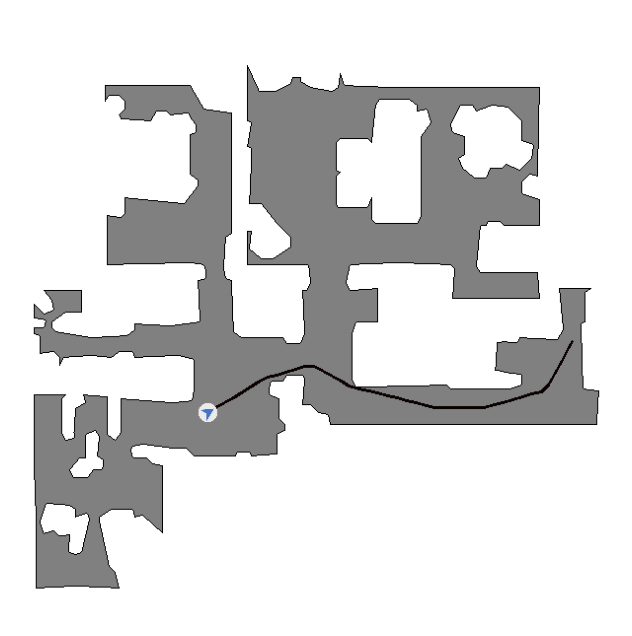

In [67]:
meters_per_pixel = 0.025
scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb
height = sim.pathfinder.get_bounds()[0][1]
top_down_map = maps.get_topdown_map(
    sim.pathfinder, height, meters_per_pixel=meters_per_pixel
)
recolor_map = np.array(
    [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
)
top_down_map = recolor_map[top_down_map]
grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
# convert world trajectory points to maps module grid points
reference_trajectory = [
    maps.to_grid(
        path_point[2],
        path_point[0],
        grid_dimensions,
        pathfinder=sim.pathfinder,
    )
    for path_point in reference_path_points
]
reference_path_grid_tangent = mn.Vector2(
    reference_trajectory[1][1] - reference_trajectory[0][1], reference_trajectory[1][0] - reference_trajectory[0][0]
)
reference_path_initial_tangent = reference_path_grid_tangent / reference_path_grid_tangent.length()

reference_path_initial_angle = math.atan2(reference_path_initial_tangent[0], reference_path_initial_tangent[1])
# draw the agent and trajectory on the map
maps.draw_path(top_down_map, reference_trajectory)
maps.draw_agent(
    top_down_map, reference_trajectory[0], reference_path_initial_angle, agent_radius_px=10
)
print("\nDisplay the reference map with agent and path overlay:")
display_map(top_down_map)

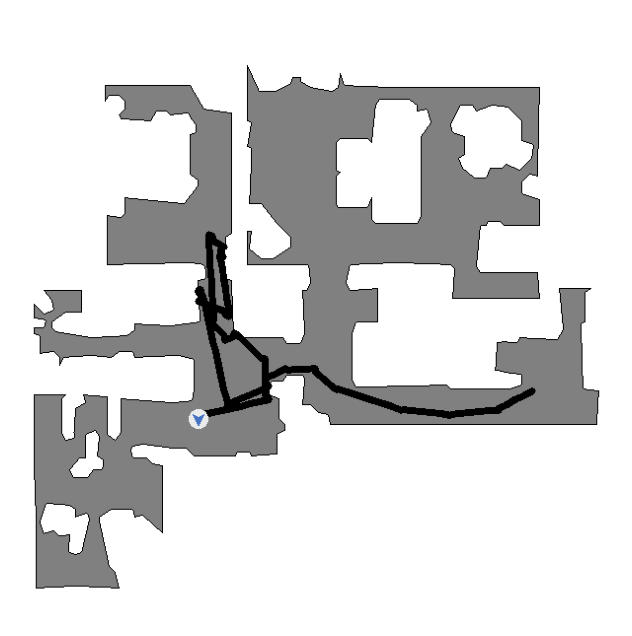

In [68]:
top_down_map = maps.get_topdown_map(
    sim.pathfinder, height, meters_per_pixel=meters_per_pixel
)
top_down_map = recolor_map[top_down_map]
result_trajectory = [
    maps.to_grid(
        path_point[2],
        path_point[0],
        grid_dimensions,
        pathfinder=sim.pathfinder,
    )
    for path_point in result_path_points
]

result_path_initial_tangent = mn.Vector2(
    result_path_points[1][1] - result_path_points[0][1], result_path_points[1][0] - result_path_points[0][0]
)

result_path_initial_tangent = result_path_initial_tangent / result_path_initial_tangent.length()

result_path_initial_angle = math.atan2(result_path_initial_tangent[0], result_path_initial_tangent[1])
# draw the agent and trajectory on the map
maps.draw_path(top_down_map, result_trajectory, color=1, thickness=5)
maps.draw_agent(
    top_down_map, result_trajectory[0], result_path_initial_angle, agent_radius_px=10
)
display_map(top_down_map)

Rendering observations at path points:
['<START>Exit the bedroom and take the first left<STEP>Walk down the hall until you reach the stairs<STOP>']



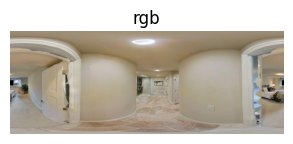

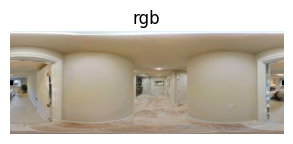

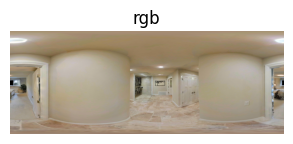

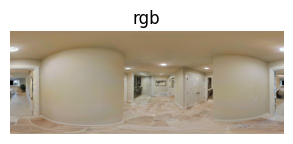

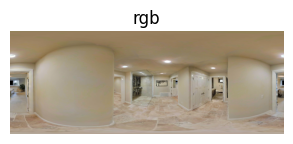

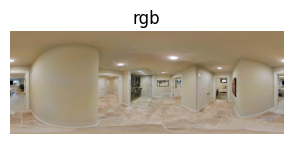

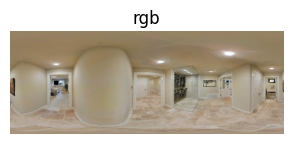

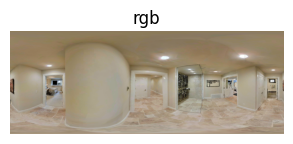

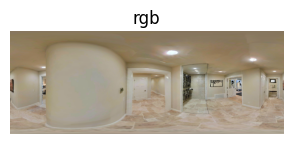

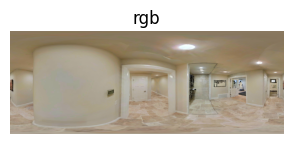

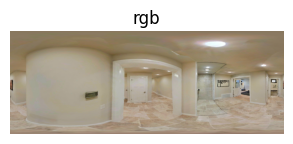

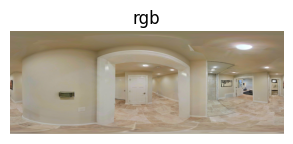

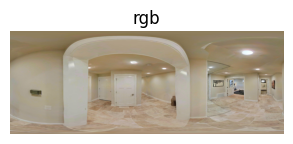

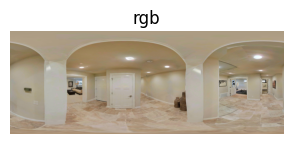

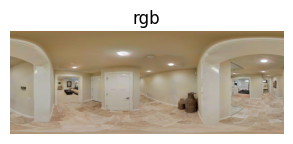

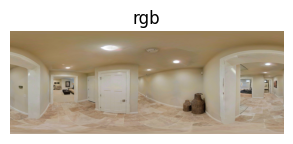

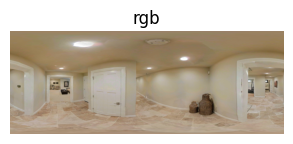

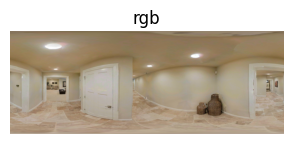

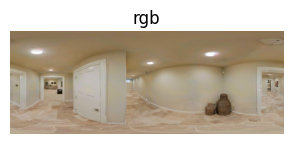

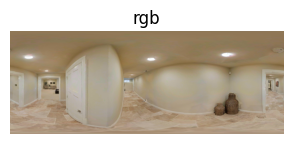

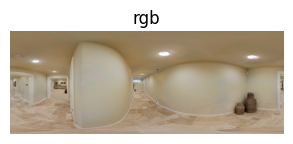

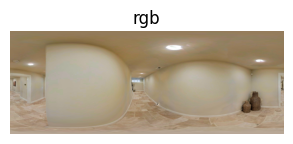

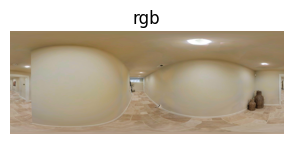

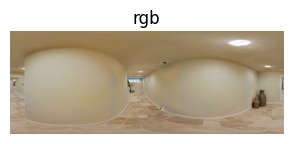

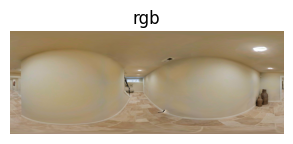

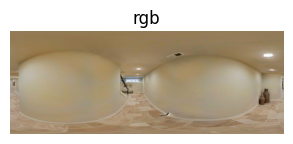

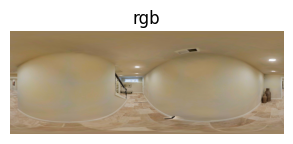

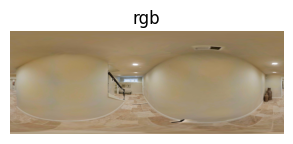

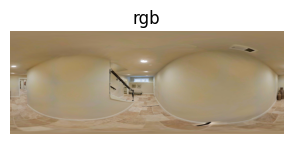

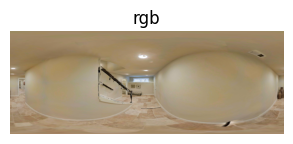

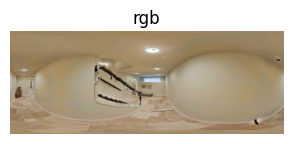

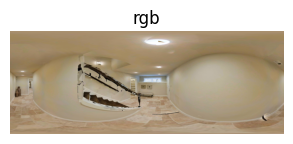

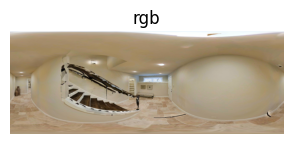

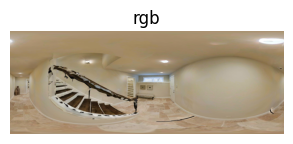

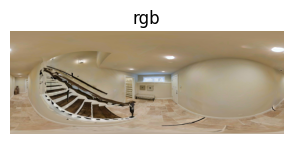

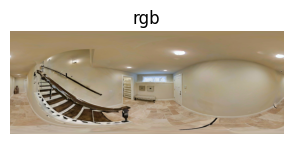

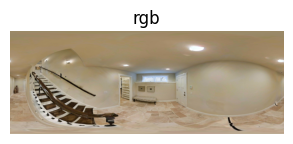

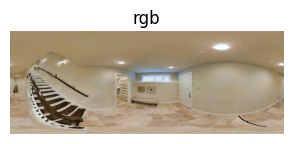

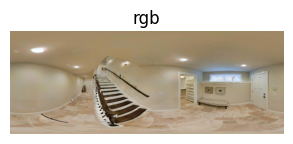

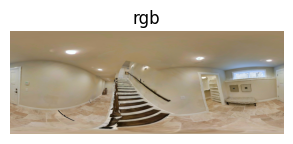

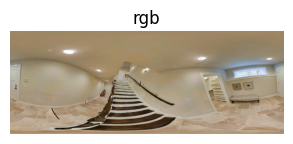

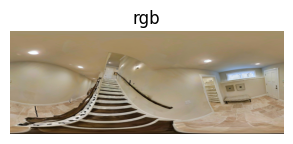

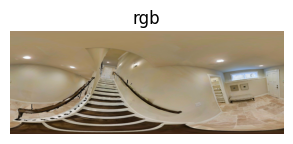

In [51]:
print("Rendering observations at path points:")
print(val_unseen_episode[test_direction]['instruction']['instruction_text'])
# print(val_unseen_episode['reverse']['instruction']['instruction_text'])
tangent = reference_path_points[1] - reference_path_points[0]
agent_state = habitat_sim.AgentState()
for ix, point in enumerate(reference_path_points):
    if ix < len(reference_path_points) - 1:
        tangent = reference_path_points[ix + 1] - point
    agent_state.position = point
    tangent_orientation_matrix = mn.Matrix4.look_at(
        point, point + tangent, np.array([0, 1.0, 0])
    )
    tangent_orientation_q = mn.Quaternion.from_matrix(
        tangent_orientation_matrix.rotation()
    )
    agent_state.rotation = utils.quat_from_magnum(tangent_orientation_q)
    agent.set_state(agent_state)
    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]

    display_sample(rgb_obs=rgb)

Rendering observations at path points:
['<START>Exit the bedroom and take the first left<STEP>Walk down the hall until you reach the stairs<STOP>']



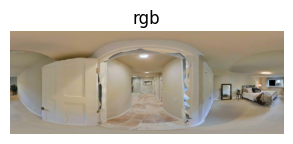

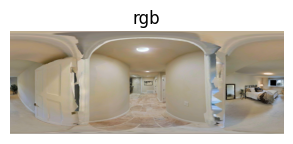

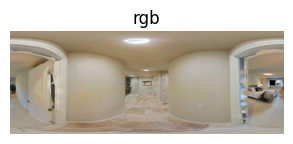

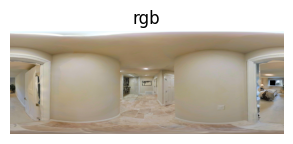

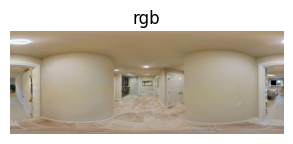

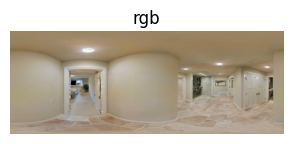

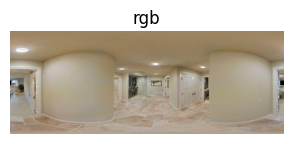

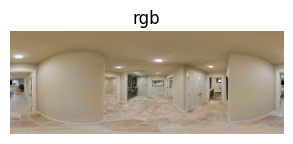

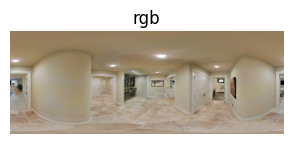

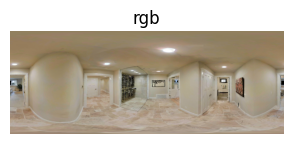

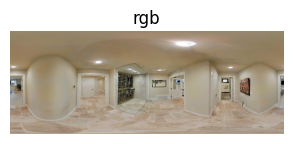

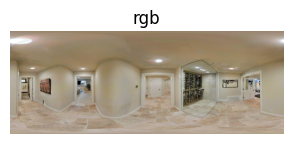

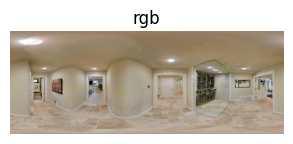

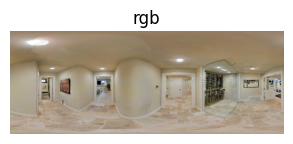

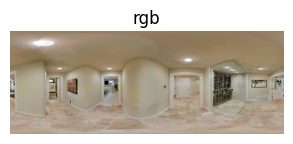

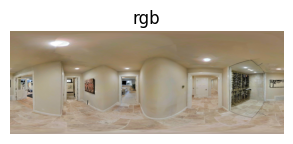

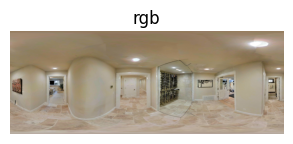

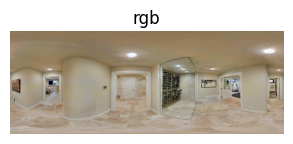

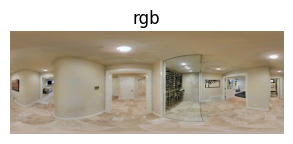

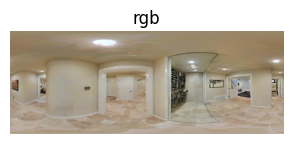

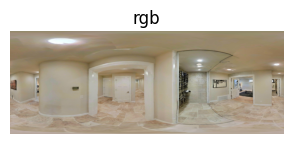

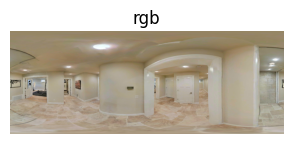

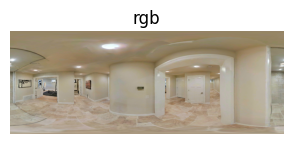

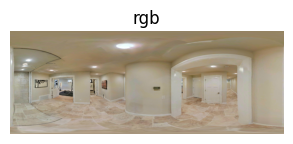

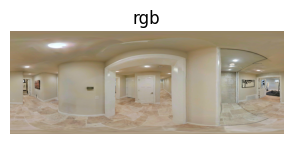

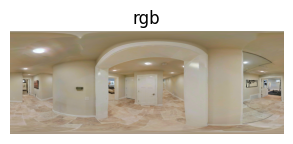

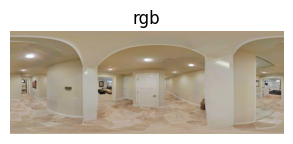

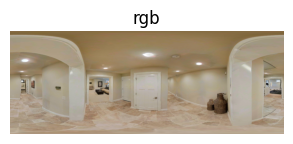

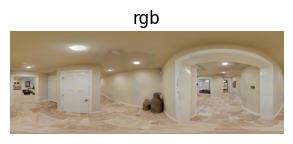

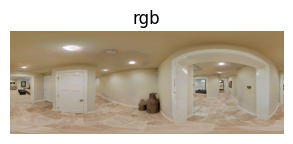

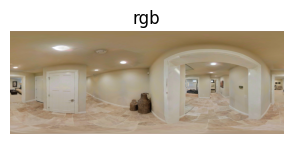

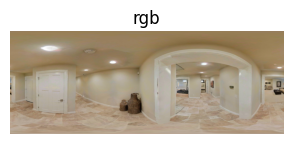

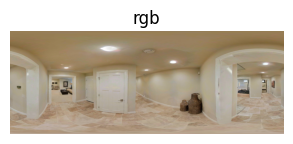

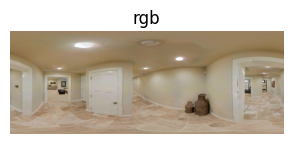

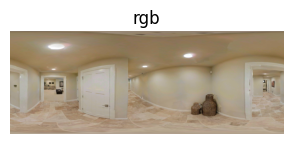

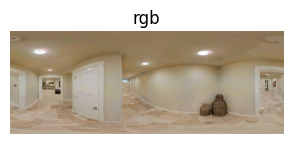

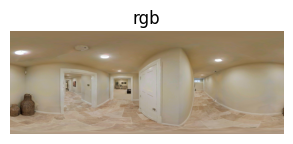

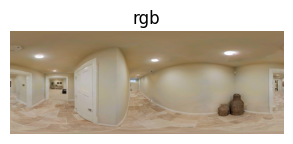

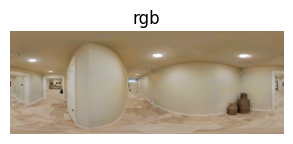

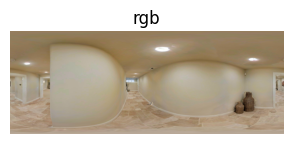

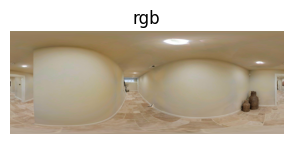

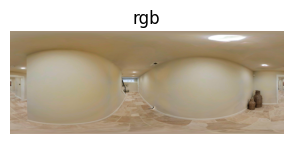

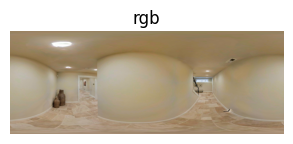

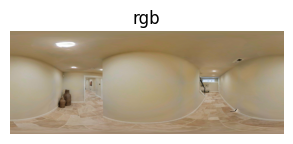

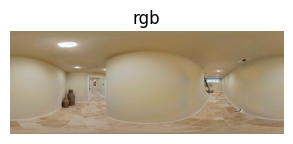

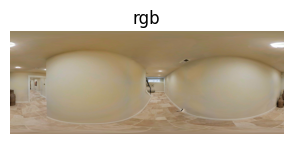

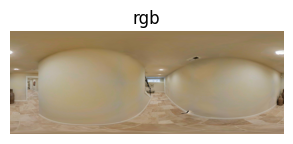

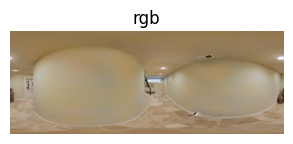

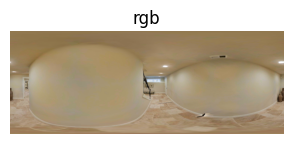

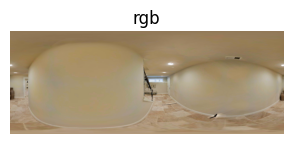

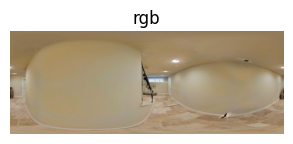

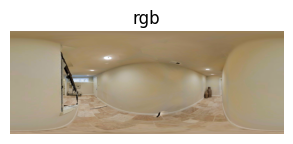

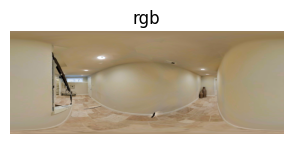

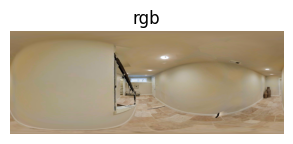

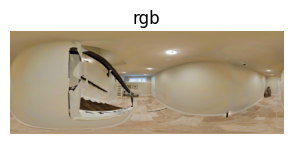

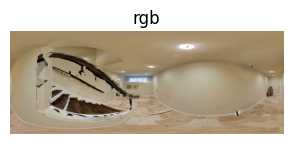

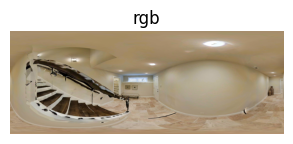

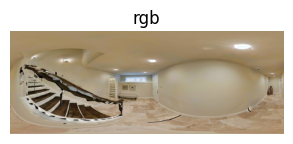

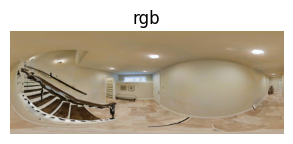

In [52]:
print("Rendering observations at path points:")
print(val_unseen_episode[test_direction]['instruction']['instruction_text'])
tangent = result_path_points[1] - result_path_points[0]
agent_state = habitat_sim.AgentState()
for ix, point in enumerate(result_path_points):
    if ix < len(result_path_points) - 1:
        tangent = result_path_points[ix + 1] - point
    agent_state.position = point
    tangent_orientation_matrix = mn.Matrix4.look_at(
        point, point + tangent, np.array([0, 1.0, 0])
    )
    tangent_orientation_q = mn.Quaternion.from_matrix(
        tangent_orientation_matrix.rotation()
    )
    agent_state.rotation = utils.quat_from_magnum(tangent_orientation_q)
    agent.set_state(agent_state)
    observations = sim.get_sensor_observations()
    rgb = observations["color_sensor"]

    display_sample(rgb_obs=rgb)

In [7]:
def cal_dtw(shortest_distances, prediction, reference, success=None, threshold=3.0):
    dtw_matrix = np.inf * np.ones((len(prediction) + 1, len(reference) + 1))
    dtw_matrix[0][0] = 0
    for i in range(1, len(prediction)+1):
        for j in range(1, len(reference)+1):
            best_previous_cost = min(
                dtw_matrix[i-1][j], dtw_matrix[i][j-1], dtw_matrix[i-1][j-1])
            cost = shortest_distances[prediction[i-1]][reference[j-1]]
            dtw_matrix[i][j] = cost + best_previous_cost

    dtw = dtw_matrix[len(prediction)][len(reference)]
    ndtw = np.exp(-dtw/(threshold * len(reference)))
    if success is None:
        success = float(shortest_distances[prediction[-1]][reference[-1]] < threshold)
    sdtw = success * ndtw

    return {
        'DTW': dtw,
        'nDTW': ndtw,
        'SDTW': sdtw
    }

def rm_stopwords(text: str):
    return " ".join([word for word in text if word.strip() not in stopwords.words('english')])

In [210]:
from transformers import BertTokenizer
import numpy as np
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.symbols import nsubj, VERB
from spacy import displacy
nlp = spacy.load("en_core_web_lg")
nlp

In [223]:
tz = BertTokenizer.from_pretrained("bert-base-uncased")


('Walk columns make sharp turn right. Walk steps stop landing.',
 'Stand bottom staircase large room red carpet. Turn around face staircase chandelier. Walk steps stop landing. Walk columns make sharp turn left. Walk one flight stairs stop landing',
 'Enter bedroom take first left. Walk bathroom.',
 'landing stop stairs flight one Walk left. turn sharp make columns Walk landing. stop steps Walk chandelier. staircase face around Turn carpet. red room large staircase bottom Stand')

([3328, 2830, 2735, 2157, 5108, 2175, 5108, 1012],
 'walk forward turn right stairs go stairs.')

([3233,
  3953,
  10714,
  2312,
  2282,
  2417,
  10135,
  1012,
  2735,
  2105,
  2227,
  10714,
  9212,
  9247,
  3771,
  1012,
  3328,
  4084,
  2644,
  4899,
  1012,
  3328,
  7753,
  2191,
  4629,
  2735,
  2187,
  1012,
  3328,
  2028,
  3462,
  5108,
  2644,
  4899],
 'Stand bottom staircase large room red carpet. Turn around face staircase chandelier. Walk steps stop landing. Walk columns make sharp turn left. Walk one flight stairs stop landing')

([4607, 5010, 2202, 2034, 2187, 1012, 3328, 5723, 1012],
 'Enter bedroom take first left. Walk bathroom.')

In [154]:
s1 = "hill is an area of land that is higher than the land that surrounds it."
s2 = "mound of something is a large rounded pile of it."
# [hill, area, land, higher, than, surrounds, it, mound, something, large, rounded, pile].

walk forward then turn right at the stair then go down the stair .


In [156]:
print(f'{"Text with Whitespace":22}{"Is Alphanumeric?":15}{"Is Punctuation?":18}{"Is Stop Word?"}')
for token in reverse_text_doc:
    print(f"{str(token.text_with_ws):22}{str(token.is_alpha):15}{str(token.is_punct):18}{str(token.is_stop)}")

Text with Whitespace  Is Alphanumeric?Is Punctuation?   Is Stop Word?
Stand                 True           False             False
at                    True           False             True
the                   True           False             True
bottom                True           False             True
of                    True           False             True
staircase             True           False             False
in                    True           False             True
the                   True           False             True
large                 True           False             False
room                  True           False             False
with                  True           False             True
red                   True           False             False
carpet                True           False             False
.                     False          True              False
Turn                  True           False             False
around                

In [101]:
for token in text1:
    print(
        f"""TOKEN: {str(token)}
        =====
        TAG: {str(token.tag_):10} POS: {token.pos_}
        EXPLANATION: {spacy.explain(token.tag_)}"""
    )

TOKEN: Start
        =====
        TAG: VB         POS: VERB
        EXPLANATION: verb, base form
TOKEN: from
        =====
        TAG: IN         POS: ADP
        EXPLANATION: conjunction, subordinating or preposition
TOKEN: the
        =====
        TAG: DT         POS: DET
        EXPLANATION: determiner
TOKEN: stairs
        =====
        TAG: NNS        POS: NOUN
        EXPLANATION: noun, plural
TOKEN: and
        =====
        TAG: CC         POS: CCONJ
        EXPLANATION: conjunction, coordinating
TOKEN: walk
        =====
        TAG: VB         POS: VERB
        EXPLANATION: verb, base form
TOKEN: forward
        =====
        TAG: RB         POS: ADV
        EXPLANATION: adverb
TOKEN: down
        =====
        TAG: IN         POS: ADP
        EXPLANATION: conjunction, subordinating or preposition
TOKEN: the
        =====
        TAG: DT         POS: DET
        EXPLANATION: determiner
TOKEN: hall
        =====
        TAG: NN         POS: NOUN
        EXPLANATION: noun, s

In [317]:
forward_text = 'walk forward then turn right at the stairs then go down the stairs.'
forward_text2 = 'Walk between the columns and make a sharp turn right. Walk down the steps and stop on the landing.'
forward_text3 = 'Walk down one flight of stairs and stop on the landing.'
reverse_text = 'Stand at the bottom of staircase in the large room with red carpet. Turn around to face staircase with a chandelier. Walk up the steps and stop on the landing. Walk between the columns and make a sharp turn left. Walk up one flight of stairs and stop on the landing'
unrelated_text = 'Enter the bedroom and take the first left. Walk to the the bathroom.'

reverse_text_list = reverse_text.split()
forward_text_list = forward_text.split()
unrelated_text_list = unrelated_text.split()

forward = rm_stopwords(forward_text_list)
reverse = rm_stopwords(reverse_text_list)

reverse_reverse = rm_stopwords(reverse_text_list[::-1])

unrelated = rm_stopwords(unrelated_text_list)
forward_text_doc= nlp(forward_text)
reverse_of_forward_text_doc= nlp(forward_text[::-1])

reverse_text_doc= nlp(reverse_text)
reverse_of_reverse_text_doc= nlp(reverse_text[::-1])

unrelated_text_doc= nlp(unrelated_text)

print(" ".join([token.lemma_ for token in forward_text_doc]))
forw_output_tokens = tz.convert_tokens_to_ids(tz.tokenize(forward))
reve_output_tokens = tz.convert_tokens_to_ids(tz.tokenize(reverse))
unrel_output_tokens = tz.convert_tokens_to_ids(tz.tokenize(unrelated))
forward, reverse, unrelated, reverse_reverse

walk forward then turn right at the stair then go down the stair .


('walk forward turn right stairs go stairs.',
 'Stand bottom staircase large room red carpet. Turn around face staircase chandelier. Walk steps stop landing. Walk columns make sharp turn left. Walk one flight stairs stop landing',
 'Enter bedroom take first left. Walk bathroom.',
 'landing stop stairs flight one Walk left. turn sharp make columns Walk landing. stop steps Walk chandelier. staircase face around Turn carpet. red room large staircase bottom Stand')

In [318]:
nouns = []
verbs = []
lemmas = []
for token in reverse_text_doc:
    if token.pos_ == "NOUN":
        nouns.append(token)
    if token.pos_ == "VERB":
        verbs.append(token)
nouns, adjectives

([bottom,
  staircase,
  room,
  carpet,
  staircase,
  chandelier,
  steps,
  landing,
  columns,
  turn,
  flight,
  stairs,
  landing],
 [Start, walk, Enter])

In [449]:
def cal_sentence_dtw(prediction, reference, nouns_only=False):
    if nouns_only:
        prediction = [token for token in prediction if token.pos_ == "NOUN"]
        reference = [token for token in reference if token.pos_ == "NOUN"]
    dtw_matrix = np.inf * np.ones((len(prediction) + 1, len(reference) + 1))
    dtw_matrix[0][0] = 0
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(reference) + 1):
            best_previous_cost = min(dtw_matrix[i - 1][j], dtw_matrix[i][j - 1], dtw_matrix[i - 1][j - 1])
            
            cost = 1 - prediction[i-1].similarity(reference[j-1])

            print(cost, prediction[i-1], reference[j-1])
            dtw_matrix[i][j] = cost + best_previous_cost

    dtw = dtw_matrix[len(prediction)][len(reference)]
    ndtw = np.exp(-dtw / (len(reference)))
    return {
        'DTW': dtw,
        'nDTW': ndtw,
        'dtw_matrix': dtw_matrix
    }


In [445]:
from nltk.corpus import wordnet as wn
SIMPLE_ANTONYMS = {
    'left': 'right',
    'exit the': 'enter the',
    'up': 'down',
    'ascend': 'descend',
    'into': 'out of',
    'enter the': 'leave the',
    'towards': 'away',
    'stop': 'start',
    'bottom': 'top'
}

SIMPLE_ANTONYMS.update({v: k for k, v in SIMPLE_ANTONYMS.items()})

def antonyms_for(word):
    antonyms = set()
    any_pos_antonyms = []
        
    for ss in wn.synsets(word):
        for lemma in ss.lemmas():
            any_pos_antonyms = [ antonym.name() for antonym in lemma.antonyms() ]
            for antonym in any_pos_antonyms:
                antonym_synsets = wn.synsets(antonym)
                if wn.VERB not in [ ss.pos() for ss in antonym_synsets ]:
                    continue
                antonyms.add(antonym)
    return list(antonyms)
SIMPLE_ANTONYMS

{'left': 'right',
 'exit the': 'enter the',
 'up': 'down',
 'ascend': 'descend',
 'into': 'out of',
 'enter the': 'exit the',
 'towards': 'away',
 'stop': 'start',
 'bottom': 'top',
 'right': 'left',
 'down': 'up',
 'descend': 'ascend',
 'out of': 'into',
 'leave the': 'enter the',
 'away': 'towards',
 'start': 'stop',
 'top': 'bottom'}

In [446]:
reversed_instr = []
for token in nlp(reverse_reverse):
#     anto = antonyms_for(token)
    found = False
    for simtok, antonym in SIMPLE_ANTONYMS.items():
        if token.similarity(nlp(simtok)) > 0.7:
            reversed_instr.append(antonym)
            found = True
            break
#     if len(anto) == 0:
#         reversed_instr.append(token)
    if not found:
        reversed_instr.append(token.lemma_)
reversed_instr = " ".join(reversed_instr)
reversed_instr, forward

('landing start stair flight one Walk right . turn sharp make column Walk landing . start step walk chandelier . staircase face around Turn carpet . red room large staircase top Stand',
 'walk forward turn right stairs go stairs.')

In [293]:
for ent in reverse_text_doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

one 221 224 CARDINAL


In [294]:
forward_text_doc.similarity(reverse_text_doc)

0.812086803467553

In [295]:
displacy.render(forward_text_doc,style="ent",jupyter=True)

In [461]:
def similarity(sentence1, sentence2, nouns_only=False):
    sentence1_doc= nlp(sentence1)
    sentence2_doc= nlp(sentence2)
    
    def is_token_allowed(token):
        return bool(token and str(token).strip() and not token.is_stop and not token.is_punct)

    def preprocess_token(token):
        return token.lemma_.strip().lower()

    sentence1_tokens = [
        preprocess_token(token)
        for token in sentence1_doc
        if is_token_allowed(token)
    ]
    
    sentence2_tokens = [
        preprocess_token(token)
        for token in sentence2_doc
        if is_token_allowed(token)
    ]
    
    sentence1_doc = nlp(" ".join(sentence1_tokens))
    sentence2_doc = nlp(" ".join(sentence2_tokens))

#     sentence1 = rm_stopwords(sentence1.split())
#     sentence2 = rm_stopwords(sentence2.split())
#     sent1_list, sent2_list = sentence1_doc.split(), sentence2_doc.split()
    sent1_set, sent2_set = dict.fromkeys(sentence1_doc), dict.fromkeys(sentence2_doc)
    sent_union = sent1_set.copy()
    sent_union.update(sent2_set)
    sent_union = list(sent_union)
    
    sentence1_vect = np.array([list(sent1_set).index(word) + 1 if word in sentence1 else 0 for word in sent_union])
    sentence2_vect = np.array([list(sent2_set).index(word) + 1 if word in sentence2 else 0 for word in sent_union])

#     sentence1_vect = [sent_union.index(word) + 1 if word in sent_union else 0 for word in sent1_set.keys()]
#     sentence2_vect = [sent_union.index(word) + 1 if word in sent_union else 0 for word in sent2_set.keys()]

#     len_sent1 = len(sentence1_vect)
#     sentence1_vect += [0] * len(sentence2_vect)
#     sentence2_vect = [0] * len_sent1 + sentence2_vect
    sim_or = 1 - (np.linalg.norm(sentence1_vect-sentence2_vect)/np.linalg.norm(sentence1_vect+sentence2_vect))
    
    sim_w = sentence1_doc.similarity(sentence2_doc)
    
    dtw = cal_sentence_dtw(sentence1_doc, sentence2_doc, nouns_only)
    ndtw = dtw['nDTW'] 
    
    sim = (0.4 * sim_or) + 0.2 * sim_w + 0.5 * ndtw
    return sim, sim_or, sim_w, ndtw

In [470]:
similarity(reverse, reversed_instr, nouns_only=False)

0.8149937093257904 stand land
0.6145499050617218 stand start
0.7362452447414398 stand stair
0.7696239650249481 stand flight
0.4975821375846863 stand walk
0.49420028924942017 stand right
0.48554491996765137 stand turn
0.767976775765419 stand sharp
0.8711380958557129 stand column
0.4975821375846863 stand walk
0.6982655823230743 stand landing
0.6145499050617218 stand start
0.6084496378898621 stand step
0.4975821375846863 stand walk
0.7468060255050659 stand chandelier
0.7315059304237366 stand staircase
0.6012325584888458 stand face
0.48554491996765137 stand turn
0.8559465855360031 stand carpet
0.8839400410652161 stand red
0.7313885986804962 stand room
0.7987682521343231 stand large
0.7315059304237366 stand staircase
0.0 stand stand
0.8949657306075096 staircase land
0.8346786648035049 staircase start
0.13316583633422852 staircase stair
0.7793804854154587 staircase flight
0.6275007724761963 staircase walk
0.7331273853778839 staircase right
0.7519374191761017 staircase turn
0.7975081652402878

(0.45427837630340506, 0.0, 0.9809533593613001, 0.5161754088622901)

In [430]:
cal_dtw(forw_output_tokens, forw_output_tokens)

AttributeError: 'int' object has no attribute 'similarity'

In [88]:
cal_dtw(reve_output_tokens[::-1], forw_output_tokens)

{'DTW': 315.0,
 'nDTW': 0.31408606593582744,
 'dtw_matrix': array([[  0.,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf],
        [ inf,   0.,   1.,   3.,   6.,  10.,  15.,  21.,  28.],
        [ inf,   1.,   0.,   1.,   3.,   6.,  10.,  15.,  21.],
        [ inf,   3.,   1.,   0.,   1.,   1.,   4.,   4.,   9.],
        [ inf,   6.,   3.,   1.,   0.,   1.,   3.,   6.,   8.],
        [ inf,  10.,   6.,   3.,   1.,   0.,   1.,   3.,   6.],
        [ inf,  10.,  10.,   6.,   3.,   1.,   0.,   1.,   3.],
        [ inf,  16.,  15.,  10.,   6.,   3.,   1.,   0.,   0.],
        [ inf,  23.,  21.,  15.,  10.,   6.,   3.,   1.,   0.],
        [ inf,  31.,  28.,  15.,  15.,  10.,   6.,   3.,   1.],
        [ inf,  40.,  36.,  22.,  21.,  15.,  10.,   6.,   3.],
        [ inf,  50.,  45.,  30.,  28.,  21.,  15.,  10.,   6.],
        [ inf,  61.,  55.,  39.,  36.,  28.,  21.,  15.,  10.],
        [ inf,  61.,  66.,  49.,  45.,  36.,  28.,  21.,  15.],
        [ inf,  74.,  73.,  60.,  55.,  45., 